# NAIVE BAYES SPAM FILTER
CMSC 197, Problem Set 2

Description:
For this problem set, we are tasked to create a spam classification model by implementing Naive Bayes Classifier.

Submitted by: John Markton M. Olarte
Submitted to: Ma'am Ara Abigail E. Ambita

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn # To be use only for standardization, splitting of datasets, model evaluation and comparison
import seaborn as sns

## PREPROCESSING

### Preprocessing was done in the hw6-oalrte_preprocessing.ipynb notebook. Hence in this part we are only going to import the preprocessed data.

In [2]:
# Load the dataset (type a)
# I have made other classifier based on the other dataset types which can be accessed in the ./additional_notebooks directory
main_df = pd.read_csv("./preprocessed_files/preprocessed_emails_a.csv")

# Split the dataset into training and testing
# Folders 0-70 are training, 71-126 are testing
train_df = main_df[main_df['folder'] <= 70]
test_df = main_df[main_df['folder'] > 70]

# Split training to spam and ham
train_spam_df = train_df[train_df['category'] == 1]
train_ham_df = train_df[train_df['category'] == 0]

In [3]:
main_df

,folder,file,email_message,category
0,0,0,mailing list queried weeks ago running set arc...,0
1,0,1,luxury watches buy rolex rolex cartier bvlgari...,1
2,0,2,academic qualifications prestigious nonacc red...,1
3,0,3,greetings verify subscription planfans list ch...,0
4,0,4,chauncey conferred luscious continued tonsillitis,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,20,prosperous future increased money earning powe...,1


In [4]:
train_spam_df

,folder,file,email_message,category
1,0,1,luxury watches buy rolex rolex cartier bvlgari...,1
2,0,2,academic qualifications prestigious nonacc red...,1
4,0,4,chauncey conferred luscious continued tonsillitis,1
7,0,7,nbc today  body diet beaches magazines hollyw...,1
8,0,8,oil sector going crazy weekly gift kkpt thing ...,1
...,...,...,...,...
21294,70,294,txtadd,1
21295,70,295,btijclnab binpqnejgmb httpgethighbizez bl...,1
21296,70,296,special offer adobe video collection adobe pre...,1
21297,70,297,doctype html public wcdtd html transitionalen ...,1


In [5]:
train_ham_df

,folder,file,email_message,category
0,0,0,mailing list queried weeks ago running set arc...,0
3,0,3,greetings verify subscription planfans list ch...,0
5,0,5,quiet quiet well straw poll plan running,0
6,0,6,working departed totally bell labs recommended...,0
10,0,10,greetings mass acknowledgement signed planfans...,0
...,...,...,...,...
21270,70,270,equation generate prime numbers equation theor...,0
21271,70,271,equation generate prime numbers equation theor...,0
21288,70,288,dear dmdx users guidance generating dmdx item ...,0
21293,70,293,built handyboard works great testmotor passes ...,0


In [6]:
test_df

,folder,file,email_message,category
21300,71,0,hesitantly derive perverse satisfaction clodho...,1
21301,71,1,things perform experiment display will remain ...,0
21302,71,2,best offer month viggra ci ialis vaiium xa naa...,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1
21304,71,4,special offer adobe video collection adobe pre...,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,20,prosperous future increased money earning powe...,1


We need to extract a list of unique words from the training set with its total occurence in the training set. Limit to 10,000 words.

In [7]:
# From training_df, get the top 10000 words and their counts (store this in a dictionary)
dict_words = {}

for index, row in train_df.iterrows():
    for word in str(row['email_message']).split():
        if word in dict_words:
            dict_words[word] += 1
        else:
            dict_words[word] = 1

# Sort the dictionary by value (descending)
sorted_dict = sorted(dict_words.items(), key=lambda x: x[1], reverse=True)

# Get the top 10000 words
top_10000_words = dict(sorted_dict[:10000])
# We will also create a list of the top 10000 words
# This will be useful for the instances where we need just the words
top_10000_words_list = list(top_10000_words.keys())
top_10000_words

{'\x1bb\x1bb': 16621,
 'will': 11325,
 'board': 5169,
 'company': 4523,
 'price': 4497,
 'gold': 4252,
 'email': 4086,
 'list': 3950,
 'adobe': 3913,
 'time': 3830,
 'nil': 3830,
 'help': 3801,
 'send': 3655,
 'message': 3611,
 'subject': 3568,
 'dont': 3563,
 'crustl': 3295,
 'received': 3093,
 'program': 3081,
 'è': 2882,
 'windows': 2867,
 'work': 2782,
 'professional': 2782,
 'wrote': 2688,
 'well': 2650,
 'ms': 2599,
 'good': 2498,
 'china': 2484,
 'number': 2463,
 'university': 2436,
 'problem': 2361,
 'file': 2247,
 'office': 2247,
 'stock': 2243,
 'handyboard': 2231,
 'hb': 2190,
 'bit': 2188,
 'de': 2170,
 'corp': 2142,
 'info': 2135,
 'microsoft': 2128,
 'current': 2083,
 'add': 2062,
 'studies': 2004,
 'pro': 2000,
 'contenttype': 1973,
 'news': 1971,
 'code': 1952,
 'development': 1936,
 'find': 1927,
 'womens': 1888,
 'great': 1855,
 'people': 1846,
 'â': 1832,
 'today': 1804,
 'read': 1797,
 'best': 1797,
 'system': 1775,
 'save': 1758,
 'power': 1753,
 'motor': 1746,
 'c

## CREATING THE FEATURE MATRICES


In [8]:
# Creae a feature matrix with dimensions (number of emails, 10000) for spam
# Each row is an email, each column is a word
# If the word is in the email, the value is 1, else 0

feature_matrix_spam = np.zeros((len(train_spam_df), 10000))

# Setting the feature matrix for spam
for index in range(len(train_spam_df)):
    for word in str(train_spam_df.iloc[index]['email_message']).split():
        if word in top_10000_words:
            feature_matrix_spam[index][top_10000_words_list.index(word)] = 1

feature_matrix_spam

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
# Feature matrix for ham
feature_matrix_ham = np.zeros((len(train_ham_df), 10000))

# Setting the feature matrix for ham
for index in range(len(train_ham_df)):
    for word in str(train_ham_df.iloc[index]['email_message']).split():
        if word in top_10000_words:
            feature_matrix_ham[index][top_10000_words_list.index(word)] = 1

feature_matrix_ham

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## COMPUTING THE PRIORS

In [10]:
# Computing the Prior Probability of Spam and Ham
# P(Spam) = # of spam emails / total # of emails
# P(Ham) = # of ham emails / total # of emails
n_spam = len(train_spam_df)
n_ham = len(train_ham_df)
n_train = len(train_df)

# P(Spam)
p_spam = n_spam / n_train

# P(Ham)
p_ham = n_ham / n_train

print(f"P(spam) = {p_spam}")
print(f"P(ham) = {p_ham}")

P(spam) = 0.6468075117370892
P(ham) = 0.3531924882629108


## COMPUTING THE LIKELIHOOD OF EACH WORD

In [11]:
"""
LAPLACE SMOOTHING
P(word|spam) = (spam_word_count + laplace_smoothing) / (total_spam_words + laplace_smoothing * num_classes)
P(word|ham) = (ham_word_count + laplace_smoothing) / (total_ham_words + laplace_smoothing * num_classes)
"""

# Function for computing the probability of a word given a class (spam or ham) with Laplace Smoothing
def laplace_smoothing(feature_matrix_spam, feature_matrix_ham, laplace_smoothing_val , num_classes):
    # Initialize the probability of each word given spam and ham
    p_word_given_spam = np.zeros(len(top_10000_words))
    p_word_given_ham = np.zeros(len(top_10000_words))

    # Calculate the word count for spam and ham
    spam_word_count = np.sum(feature_matrix_spam, axis=0)
    ham_word_count = np.sum(feature_matrix_ham, axis=0)

    # Calculate the total number of words in spam and ham
    total_spam_words = np.sum(spam_word_count)
    total_ham_words = np.sum(ham_word_count)

    # Compute the probability of each word given spam and ham
    for i in range(len(top_10000_words)):
        p_word_given_spam[i] = (spam_word_count[i] + laplace_smoothing_val) / (total_spam_words + laplace_smoothing_val * num_classes)
        p_word_given_ham[i] = (ham_word_count[i] + laplace_smoothing_val) / (total_ham_words + laplace_smoothing_val * num_classes)

    return p_word_given_spam, p_word_given_ham

# Initialize laplace smoothing parameter and the number of classes
laplace_smoothing_val = 1
num_classes = 2
spam_word_probs, ham_word_probs = laplace_smoothing(feature_matrix_spam, feature_matrix_ham, laplace_smoothing_val, num_classes)

# Print the word probabilities for spam and ham
print(f"spam_word_probs = {spam_word_probs}")
print(f"ham_word_probs = {ham_word_probs}")

spam_word_probs = [2.10395700e-03 5.04354435e-03 1.02336102e-03 ... 2.06045843e-05
 4.80773633e-05 2.06045843e-05]
ham_word_probs = [2.78576363e-06 6.42118518e-03 5.61888525e-03 ... 8.35729090e-06
 5.57152727e-06 3.06434000e-05]


## CLASSIFYING THE EMAILS

In [12]:
# Classify the test emails by computing the log probability of each email being spam or ham
# log(P(c|wd)) = log(P(wi|c)P(c))
# P(c|wd) = sum(log(P(wi|c) + P(c)))

# Classifier Function
def classify_email(email, spam_word_probs, ham_word_probs, p_spam, p_ham):
    # Initialize the log probability of spam and ham
    log_p_spam = 0
    log_p_ham = 0
    
    # Split the email into words
    words = str(email).split()
    
    # Compute the log probability of spam and ham
    for word in words:
        if word in top_10000_words:
            log_p_spam += np.log(spam_word_probs[top_10000_words_list.index(word)])
            log_p_ham += np.log(ham_word_probs[top_10000_words_list.index(word)])
    
    # Add the log probability of spam and ham
    log_p_spam += np.log(p_spam)
    log_p_ham += np.log(p_ham)
    
    # Return the class with the highest probability
    if log_p_spam > log_p_ham:
        return 1
    else:
        return 0

In [13]:
# Classify the train emails
train_df['predicted'] = train_df['email_message'].apply(lambda x: classify_email(x, spam_word_probs, ham_word_probs, p_spam, p_ham))

C:\Users\johnm\AppData\Local\Temp\ipykernel_19008\3905934663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['predicted'] = train_df['email_message'].apply(lambda x: classify_email(x, spam_word_probs, ham_word_probs, p_spam, p_ham))


In [14]:
# count the number of correct predictions
correct = 0
for index, row in train_df.iterrows():
    if float(row['category']) == float(row['predicted']):
        correct += 1

print(f"Correctly classified {correct} out of {len(train_df)} emails ({correct / len(train_df) * 100}%)")

Correctly classified 20374 out of 21300 emails (95.65258215962442%)


## TESTING THE CLASSIFIER

In [15]:
# Classify the test emails
test_df['predicted'] = test_df['email_message'].apply(lambda x: classify_email(x, spam_word_probs, ham_word_probs, p_spam, p_ham))
test_df

C:\Users\johnm\AppData\Local\Temp\ipykernel_19008\4266106314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted'] = test_df['email_message'].apply(lambda x: classify_email(x, spam_word_probs, ham_word_probs, p_spam, p_ham))


,folder,file,email_message,category,predicted
21300,71,0,hesitantly derive perverse satisfaction clodho...,1,1
21301,71,1,things perform experiment display will remain ...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa naa...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,prosperous future increased money earning powe...,1,1


In [16]:
# count the number of correct predictions
correct = 0
for index, row in test_df.iterrows():
    if float(row['category']) == float(row['predicted']):
        correct += 1

print(f"Correctly classified {correct} out of {len(test_df)} emails ({correct / len(test_df) * 100}%)")

Correctly classified 15360 out of 16522 emails (92.96695315337126%)


## PERFORMANCE EVALUATION

[[ 5148   239]
 [  923 10212]]


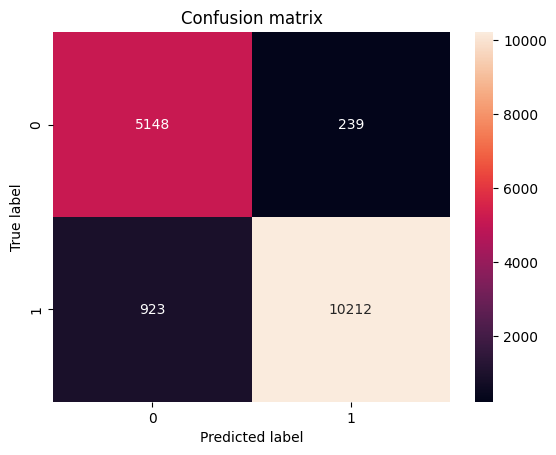

In [17]:
# Create an array of actual and predicted categories
actual = np.array(test_df['category'])
predicted = np.array(test_df['predicted'])

#  Use sklearn.metrics to compute the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, predicted, labels=[0, 1])
print(cm)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
# Calculate for accuracy, precision, recall, and F1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted)
recall = recall_score(actual, predicted)
f1 = f1_score(actual, predicted)

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 score = {f1}")

Accuracy = 0.9296695315337127
Precision = 0.9771313749880394
Recall = 0.9171082173327346
F1 score = 0.9461688131196145


## EXPLORATION (FOR ANSWERING GUIDE QUESTIONS)

### 1. What is the effect of removing stop words in terms of precision, recall, and acuracy?
For this one you can refer to the notebook located in ./additional_notebooks/hw6-olarte(f).ipynb
Which contains the classification results of the model without removing stop words from the datasets.

Results without removing stop words:
* Accuracy = 0.9116329742161966
* Precision = 0.9755234444116779
* Recall = 0.8912438257745846
* F1 score = 0.9314811338464426

Results with removing stop words (based on this notebook):
* Accuracy = 0.9296695315337127
* Precision = 0.9771313749880394
* Recall = 0.9171082173327346
* F1 score = 0.9461688131196145

In summary, removing stop words from the dataset improved the accuracy, precision, recall, and F1 score of the model. I will discuss further about this on the attached document.


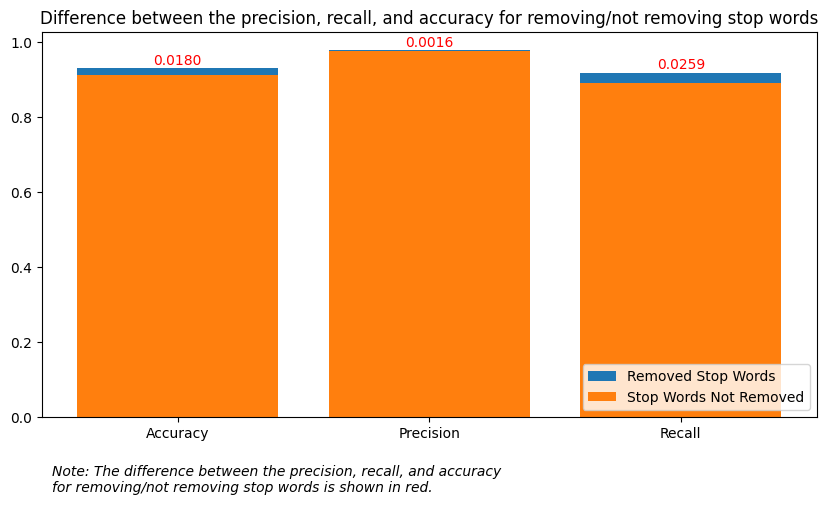

In [19]:
# Since we are required to show a plot of difference between the precision, recall, and accuracy for removing/not removing stop words.
# We will plot a graph that shows the difference between the precision, recall, and accuracy for removing/not removing stop words.

# Values for the precision, recall, and accuracy for removing stop words
accuracy_removed = accuracy
precision_removed = precision
recall_removed = recall

# Values for the precision, recall, and accuracy for not removing stop words
accuracy_not_removed = 0.9116329742161966
precision_not_removed = 0.9755234444116779
recall_not_removed = 0.8912438257745846

# Barplot precision, recall, and accuracy for removing/not removing stop words
plt.figure(figsize=(10, 5))
plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy_removed, precision_removed, recall_removed], label='Removed Stop Words')
plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy_not_removed, precision_not_removed, recall_not_removed], label='Stop Words Not Removed')
plt.text(x=0, y=accuracy_removed + 0.01, s=f"{accuracy_removed - accuracy_not_removed:.4f}", ha='center', color='red')
plt.text(x=1, y=precision_removed + 0.01, s=f"{precision_removed - precision_not_removed:.4f}", ha='center', color='red')
plt.text(x=2, y=recall_removed + 0.01, s=f"{recall_removed - recall_not_removed:.4f}", ha='center', color='red')
plt.title('Difference between the precision, recall, and accuracy for removing/not removing stop words')
plt.text(x=-0.5, y=-0.2, s='Note: The difference between the precision, recall, and accuracy \nfor removing/not removing stop words is shown in red.', ha='left', style='italic')
plt.legend(loc='lower right')
plt.show()

### 2. Experiment on the number of words used for training.

Filter the dictionary

In [20]:
# Filter Dictionary by including only top 10000 words which occurs more than k times
# For this we can reuse the sorted_dict from the previous cells

k = 50
sorted_dict = dict(sorted_dict)
sorted_dict

# Filter the dictionary (for k = 50)
filtered_dict_50 = {x: y for x, y in sorted_dict.items() if y > k}
filtered_dict_50_list = list(filtered_dict_50.keys())
print(f"Length of Filtered Dictioanry (k=50) {len(filtered_dict_50)}")

Length of Filtered Dictioanry (k=50) 5107


In [21]:
# Filter the dictionary (for k = 100)
filtered_dict_100 = {x: y for x, y in sorted_dict.items() if y > 100}
filtered_dict_100_list = list(filtered_dict_100.keys())
print(f"Length of Filtered Dictioanry (k=100) {len(filtered_dict_100)}")

Length of Filtered Dictioanry (k=100) 2822


In [22]:
# Redefine laplace_smoothing to be used with filtered dictionary
def laplace_smoothing(feature_matrix_spam, feature_matrix_ham, laplace_smoothing_val , num_classes, fil_dict):
    # Initialize the probability of each word given spam and ham
    p_word_given_spam = np.zeros(len(fil_dict))
    p_word_given_ham = np.zeros(len(fil_dict))

    # Calculate the word count for spam and ham
    spam_word_count = np.sum(feature_matrix_spam, axis=0)
    ham_word_count = np.sum(feature_matrix_ham, axis=0)

    # Calculate the total number of words in spam and ham
    total_spam_words = np.sum(spam_word_count)
    total_ham_words = np.sum(ham_word_count)

    # Compute the probability of each word given spam and ham
    for i in range(len(fil_dict)):
        p_word_given_spam[i] = (spam_word_count[i] + laplace_smoothing_val) / (total_spam_words + laplace_smoothing_val * num_classes)
        p_word_given_ham[i] = (ham_word_count[i] + laplace_smoothing_val) / (total_ham_words + laplace_smoothing_val * num_classes)

    return p_word_given_spam, p_word_given_ham

In [23]:
# Redefine the classify function to be used with filtered dictionary
def classify(email, spam_word_probs, ham_word_probs, p_spam, p_ham, fil_dict, fil_list):
    # Initialize the log probability of spam and ham
    log_p_spam = 0
    log_p_ham = 0
    
    # Split the email into words
    words = str(email).split()
    
    # Compute the log probability of spam and ham
    for word in words:
        if word in fil_dict:
            log_p_spam += np.log(spam_word_probs[fil_list.index(word)])
            log_p_ham += np.log(ham_word_probs[fil_list.index(word)])
    
    # Add the log probability of spam and ham
    log_p_spam += np.log(p_spam)
    log_p_ham += np.log(p_ham)
    
    # Return the class with the highest probability
    if log_p_spam > log_p_ham:
        return 1
    else:
        return 0

#### For k = 50

In [24]:
# Test the classifier with the filtered dictionary (k = 50)

# Creation of Feature Matrix
feature_matrix_spam = np.zeros((len(train_spam_df), len(filtered_dict_50_list)))
# Settting the feature matrix for spam
for index in range(len(train_spam_df)):
    for word in str(train_spam_df.iloc[index]['email_message']).split():
        if word in filtered_dict_50:
            feature_matrix_spam[index][filtered_dict_50_list.index(word)] = 1
feature_matrix_ham = np.zeros((len(train_ham_df), 10000))
# Setting the feature matrix for ham
for index in range(len(train_ham_df)):
    for word in str(train_ham_df.iloc[index]['email_message']).split():
        if word in filtered_dict_50:
            feature_matrix_ham[index][filtered_dict_50_list.index(word)] = 1

# Apply Laplace Smoothing
p_word_given_spam, p_word_given_ham = laplace_smoothing(feature_matrix_spam, feature_matrix_ham, 1, 2, filtered_dict_50_list)

# Copy the test_df and drop predicted column
test_df_50 = test_df.copy()
test_df_50.drop('predicted', axis=1, inplace=True)
# Test the classifier
test_df_50['predicted'] = test_df_50['email_message'].apply(lambda x: classify(x, p_word_given_spam, p_word_given_ham, p_spam, p_ham, filtered_dict_50, filtered_dict_50_list))


In [25]:
test_df_50

,folder,file,email_message,category,predicted
21300,71,0,hesitantly derive perverse satisfaction clodho...,1,1
21301,71,1,things perform experiment display will remain ...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa naa...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,prosperous future increased money earning powe...,1,1


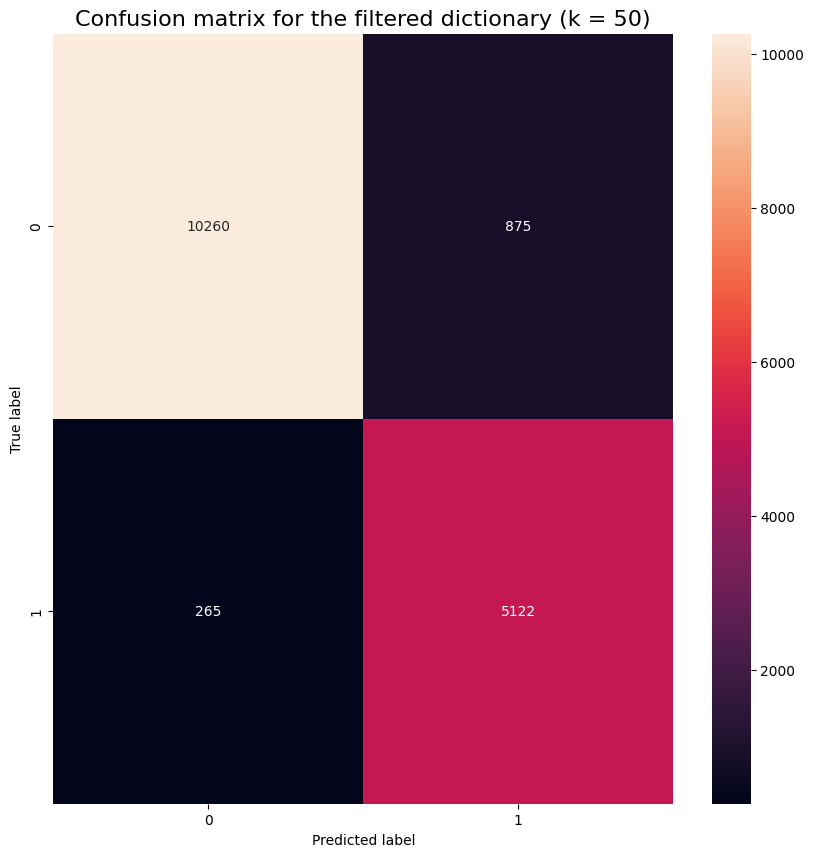

In [26]:
# Let's check the confusion matrix for the filtered dictionary (k = 50)
actual_50 = test_df_50['category']
predicted_50 = test_df_50['predicted']
cm_50 = confusion_matrix(actual_50, predicted_50, labels=[1, 0])

# Plot the confusion matrix for the filtered dictionary (k = 50)
plt.figure(figsize=(10, 10))
# Plot the confusion matrix
sns.heatmap(cm_50, annot=True, fmt='d')
plt.title('Confusion matrix for the filtered dictionary (k = 50)', fontsize=16)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [27]:
# Accuracy, Precision, Recall and F1 Score for the filtered dictionary (k = 50)
accuracy_50 = accuracy_score(actual_50, predicted_50)
precision_50 = precision_score(actual_50, predicted_50)
recall_50 = recall_score(actual_50, predicted_50)
f1_50 = f1_score(actual_50, predicted_50)

print(f"Accuracy = {accuracy_50}")
print(f"Precision = {precision_50}")
print(f"Recall = {recall_50}")
print(f"F1 score = {f1_50}")

Accuracy = 0.9310010894564823
Precision = 0.9748218527315915
Recall = 0.921418949259093
F1 score = 0.9473684210526316


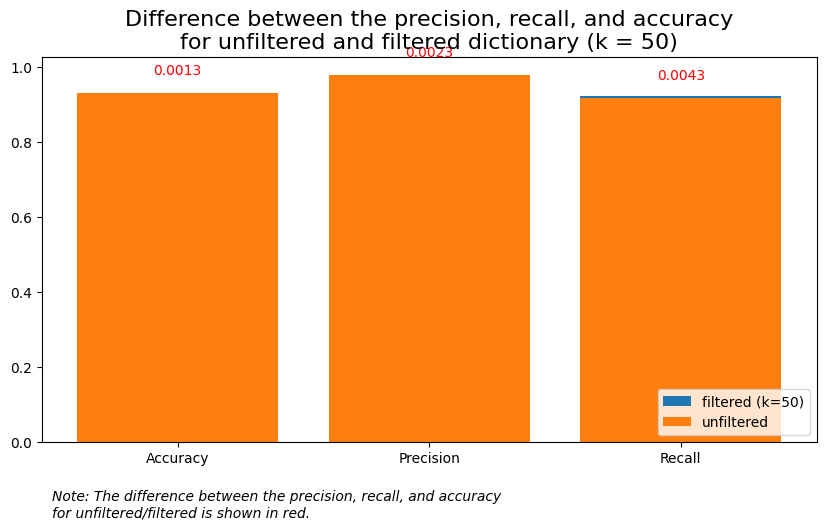

In [28]:
# We can plot the difference between the original and filtered dictionary (k = 50)

# Values for the precision, recall, and accuracy (original)
accuracy_unfiltered = accuracy
precision_unfiltered = precision
recall_unfiltered = recall

# Barplot of the precision, recall, and accuracy for unfilted and filtered dictionary (k = 50)
plt.figure(figsize=(10, 5))
plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy_50, precision_50, recall_50], label='filtered (k=50)')
plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy_unfiltered, precision_unfiltered, recall_unfiltered], label='unfiltered')
plt.text(x=0, y=accuracy_removed + 0.05, s=f"{abs(accuracy_unfiltered - accuracy_50):.4f}", ha='center', color='red')
plt.text(x=1, y=precision_removed + 0.05, s=f"{abs(precision_unfiltered - precision_50):.4f}", ha='center', color='red')
plt.text(x=2, y=recall_removed + 0.05, s=f"{abs(recall_unfiltered - recall_50):.4f}", ha='center', color='red')
plt.title('Difference between the precision, recall, and accuracy\nfor unfiltered and filtered dictionary (k = 50)', fontsize=16)
plt.text(x=-0.5, y=-0.2, s='Note: The difference between the precision, recall, and accuracy \nfor unfiltered/filtered is shown in red.', ha='left', style='italic')
plt.legend(loc='lower right')
plt.show()

#### For k = 100

In [29]:
# Train the classifier with the filtered dictionary (k = 100)

# Creation of Feature Matrix
feature_matrix_spam = np.zeros((len(train_spam_df), len(filtered_dict_100_list)))
# Settting the feature matrix for spam
for index in range(len(train_spam_df)):
    for word in str(train_spam_df.iloc[index]['email_message']).split():
        if word in filtered_dict_100:
            feature_matrix_spam[index][filtered_dict_100_list.index(word)] = 1
feature_matrix_ham = np.zeros((len(train_ham_df), 10000))
# Setting the feature matrix for ham
for index in range(len(train_ham_df)):
    for word in str(train_ham_df.iloc[index]['email_message']).split():
        if word in filtered_dict_100:
            feature_matrix_ham[index][filtered_dict_100_list.index(word)] = 1

# Apply Laplace Smoothing
p_word_given_spam, p_word_given_ham = laplace_smoothing(feature_matrix_spam, feature_matrix_ham, 1, 2, filtered_dict_100_list)

# Copy the test_df and drop predicted column
test_df_100 = test_df.copy()
test_df_100.drop('predicted', axis=1, inplace=True)
# Test the classifier
test_df_100['predicted'] = test_df_100['email_message'].apply(lambda x: classify(x, p_word_given_spam, p_word_given_ham, p_spam, p_ham, filtered_dict_100, filtered_dict_100_list))


In [30]:
test_df_100

,folder,file,email_message,category,predicted
21300,71,0,hesitantly derive perverse satisfaction clodho...,1,1
21301,71,1,things perform experiment display will remain ...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa naa...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,prosperous future increased money earning powe...,1,1


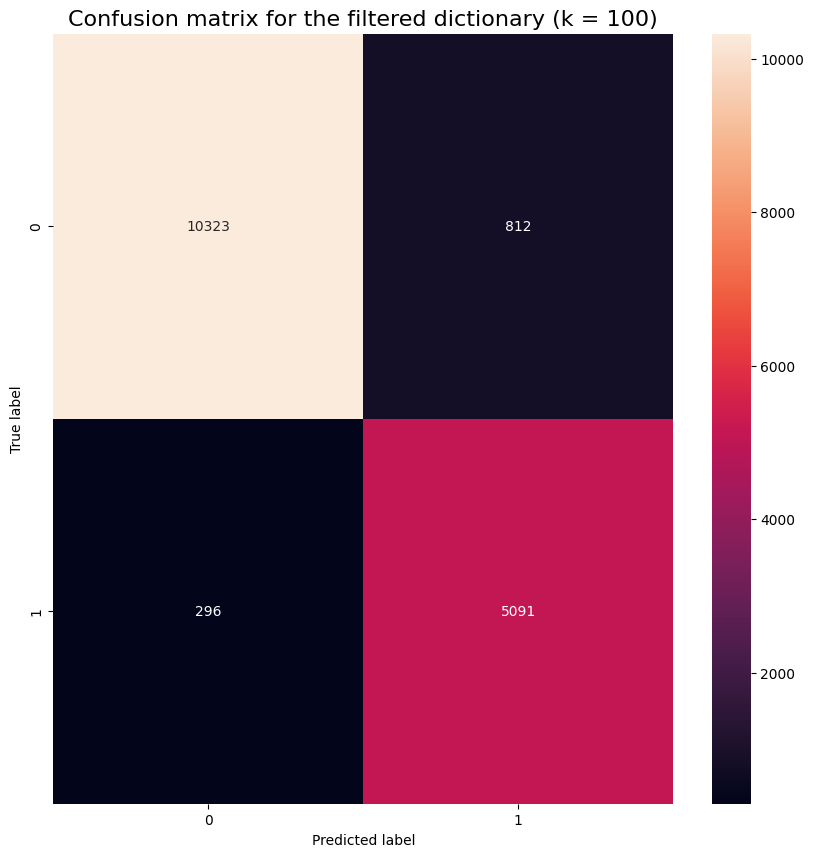

In [31]:
# Let's check the confusion matrix for the filtered dictionary (k = 100)
actual_100 = test_df_100['category']
predicted_100 = test_df_100['predicted']
cm_100 = confusion_matrix(actual_100, predicted_100, labels=[1, 0])

# Plot of the confusion matrix for the filtered dictionary (k = 100)
plt.figure(figsize=(10, 10))
sns.heatmap(cm_100, annot=True, fmt='d')
plt.title('Confusion matrix for the filtered dictionary (k = 100)', fontsize=16)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
# Accuracy, Precision, Recall and F1 Score for the filtered dictionary (k = 100)
accuracy_100 = accuracy_score(actual_100, predicted_100)
precision_100 = precision_score(actual_100, predicted_100)
recall_100 = recall_score(actual_100, predicted_100)
f1_100 = f1_score(actual_100, predicted_100)

print(f"Accuracy = {accuracy_100}")
print(f"Precision = {precision_100}")
print(f"Recall = {recall_100}")
print(f"F1 score = {f1_100}")

Accuracy = 0.9329379009805109
Precision = 0.9721254355400697
Recall = 0.9270767849124383
F1 score = 0.9490668382826146


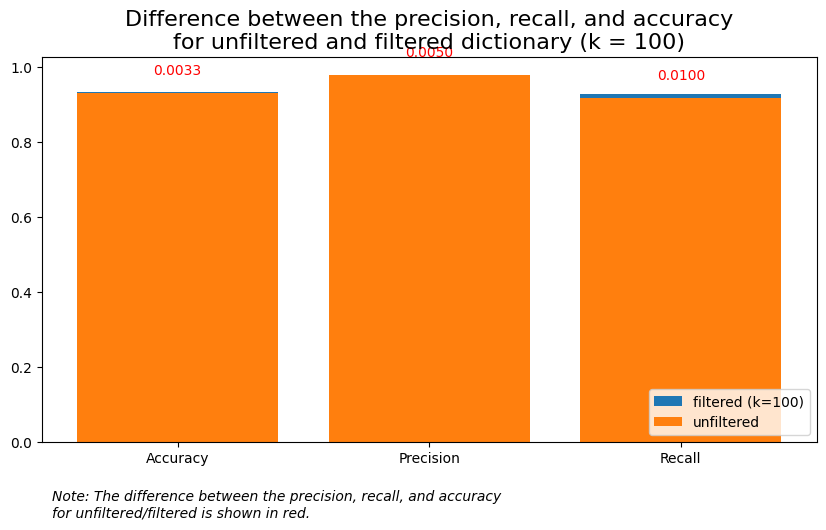

In [33]:
# We can plot the difference between the original and filtered dictionary (k = 100)

# Barplot for the precision, recall, and accuracy for unfilted and filtered dictionary (k = 100)
plt.figure(figsize=(10, 5))
plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy_100, precision_100, recall_100], label='filtered (k=100)')
plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy_unfiltered, precision_unfiltered, recall_unfiltered], label='unfiltered')
plt.text(x=0, y=accuracy_removed + 0.05, s=f"{abs(accuracy_unfiltered - accuracy_100):.4f}", ha='center', color='red')
plt.text(x=1, y=precision_removed + 0.05, s=f"{abs(precision_unfiltered - precision_100):.4f}", ha='center', color='red')
plt.text(x=2, y=recall_removed + 0.05, s=f"{abs(recall_unfiltered - recall_100):.4f}", ha='center', color='red')
plt.title('Difference between the precision, recall, and accuracy\nfor unfiltered and filtered dictionary (k = 100)', fontsize=16)
plt.text(x=-0.5, y=-0.2, s='Note: The difference between the precision, recall, and accuracy \nfor unfiltered/filtered is shown in red.', ha='left', style='italic')
plt.legend(loc='lower right')
plt.show()

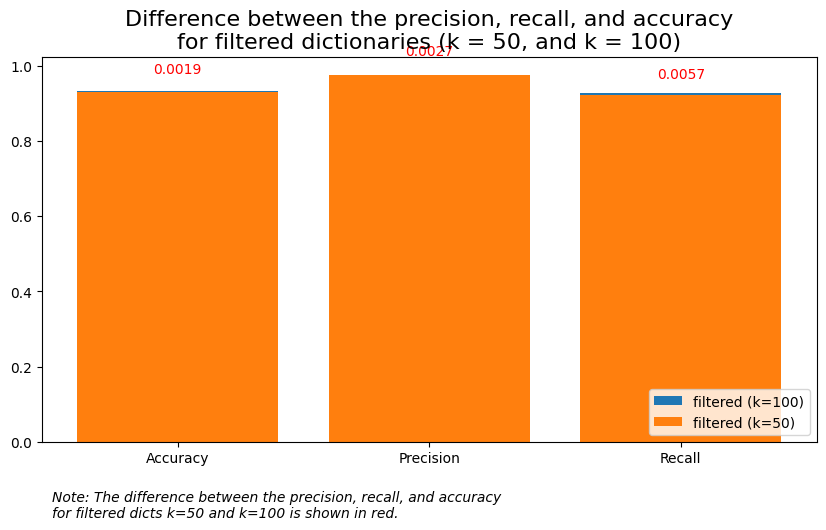

In [34]:
# Comparing filtered dictionary (k = 50) and filtered dictionary (k = 100)

# Plot the histogram for the precision, recall, and accuracy for unfilted and filtered dictionary (k = 100)
plt.figure(figsize=(10, 5))
plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy_100, precision_100, recall_100], label='filtered (k=100)')
plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy_50, precision_50, recall_50], label='filtered (k=50)')
plt.text(x=0, y=accuracy_removed + 0.05, s=f"{abs(accuracy_100 - accuracy_50):.4f}", ha='center', color='red')
plt.text(x=1, y=precision_removed + 0.05, s=f"{abs(precision_100 - precision_50):.4f}", ha='center', color='red')
plt.text(x=2, y=recall_removed + 0.05, s=f"{abs(recall_100 - recall_50):.4f}", ha='center', color='red')
plt.title('Difference between the precision, recall, and accuracy\nfor filtered dictionaries (k = 50, and k = 100)', fontsize=16)
plt.text(x=-0.5, y=-0.2, s='Note: The difference between the precision, recall, and accuracy \nfor filtered dicts k=50 and k=100 is shown in red.', ha='left', style='italic')
plt.legend(loc='lower right')
plt.show()

### 3. Different Lambda values
Note: For faster computation we will be using the filtered dictionary with k = 100.

#### For lambda = 2.0

In [35]:
# Initialize laplace smoothing parameter and the number of classes
laplace_smoothing_val = 2
num_classes = 2
spam_word_probs, ham_word_probs = laplace_smoothing(feature_matrix_spam, feature_matrix_ham, laplace_smoothing_val, num_classes, filtered_dict_100)

# Copy the test_df and drop predicted column (l2 = lambda-> 2.0)
test_df_l2 = test_df.copy()

# Classify the emails
test_df_l2['predicted'] = test_df_l2['email_message'].apply(lambda x: classify(x, spam_word_probs, ham_word_probs, p_spam, p_ham, filtered_dict_100, filtered_dict_100_list))
test_df_l2

,folder,file,email_message,category,predicted
21300,71,0,hesitantly derive perverse satisfaction clodho...,1,1
21301,71,1,things perform experiment display will remain ...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa naa...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,prosperous future increased money earning powe...,1,1


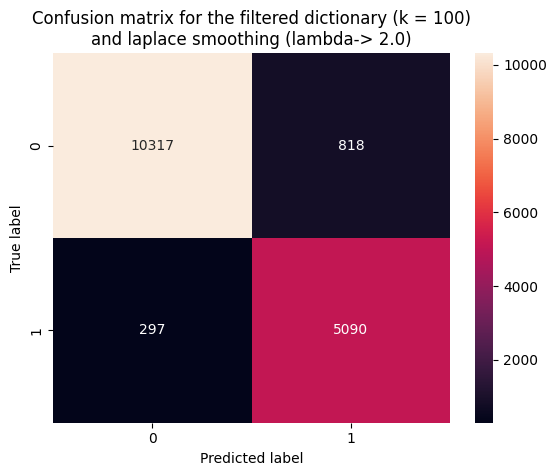

In [36]:
# Let's check the confusion matrix for the filtered dictionary (k = 100) and laplace smoothing (l2 = lambda-> 2.0)
actual_l2 = test_df_l2['category']
predicted_l2 = test_df_l2['predicted']
cm_l2 = confusion_matrix(actual_l2, predicted_l2, labels=[1, 0])

# Plot the confusion matrix
sns.heatmap(cm_l2, annot=True, fmt='d')
plt.title('Confusion matrix for the filtered dictionary (k = 100)\nand laplace smoothing (lambda-> 2.0)', fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [37]:
# Accuracy, Precision, Recall and F1 Score for the filtered dictionary (k = 100) and laplace smoothing (l2 = lambda-> 2.0)
accuaracy_l2 = accuracy_score(actual_l2, predicted_l2)
precision_l2 = precision_score(actual_l2, predicted_l2)
recall_l2 = recall_score(actual_l2, predicted_l2)
f1_l2 = f1_score(actual_l2, predicted_l2)

print(f"Accuracy = {accuaracy_l2}")
print(f"Precision = {precision_l2}")
print(f"Recall = {recall_l2}")
print(f"F1 score = {f1_l2}")

Accuracy = 0.9325142234596295
Precision = 0.9720180893159978
Recall = 0.9265379434216434
F1 score = 0.9487332750931077


#### For lambda = 0.5

In [38]:
# Initialize laplace smoothing parameter and the number of classes
laplace_smoothing_val = 0.5
num_classes = 2
spam_word_probs, ham_word_probs = laplace_smoothing(feature_matrix_spam, feature_matrix_ham, laplace_smoothing_val, num_classes, filtered_dict_100)

# Copy the test_df and drop predicted column (l0p5 = lambda-> 0.5)
test_df_l0p5 = test_df.copy()

# Classify the emails
test_df_l0p5['predicted'] = test_df_l0p5['email_message'].apply(lambda x: classify(x, spam_word_probs, ham_word_probs, p_spam, p_ham, filtered_dict_100, filtered_dict_100_list))
test_df_l0p5

,folder,file,email_message,category,predicted
21300,71,0,hesitantly derive perverse satisfaction clodho...,1,1
21301,71,1,things perform experiment display will remain ...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa naa...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,prosperous future increased money earning powe...,1,1


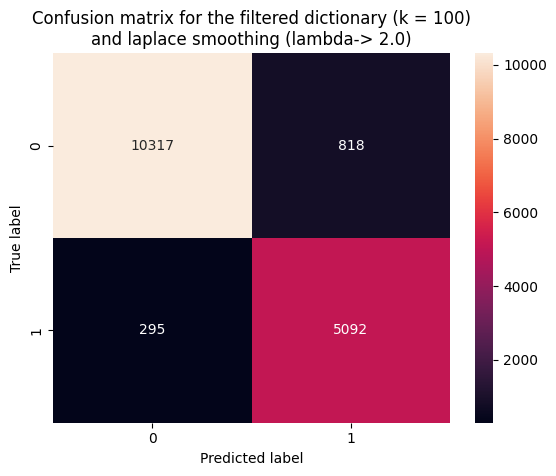

In [39]:
# Let's check the confusion matrix for the filtered dictionary (k = 100) and laplace smoothing (l0p5 = lambda-> 0.5)
actual_l0p5 = test_df_l0p5['category']
predicted_l0p5 = test_df_l0p5['predicted']
cm_l0p5 = confusion_matrix(actual_l0p5, predicted_l0p5, labels=[1, 0])

# Plot the confusion matrix
sns.heatmap(cm_l0p5, annot=True, fmt='d')
plt.title('Confusion matrix for the filtered dictionary (k = 100)\nand laplace smoothing (lambda-> 2.0)', fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [40]:
# Accuracy, Precision, Recall and F1 Score for the filtered dictionary (k = 100) and laplace smoothing (l0p5 = lambda-> 0.5)
accuaracy_l0p5 = accuracy_score(actual_l0p5, predicted_l0p5)
precision_l0p5 = precision_score(actual_l0p5, predicted_l0p5)
recall_l0p5 = recall_score(actual_l0p5, predicted_l0p5)
f1_l0p5 = f1_score(actual_l0p5, predicted_l0p5)

print(f"Accuracy = {accuaracy_l0p5}")
print(f"Precision = {precision_l0p5}")
print(f"Recall = {recall_l0p5}")
print(f"F1 score = {f1_l0p5}")

Accuracy = 0.9326352741798813
Precision = 0.9722012815680362
Recall = 0.9265379434216434
F1 score = 0.948820526969237


#### For lambda = 0.1

In [41]:
# Initialize laplace smoothing parameter and the number of classes
laplace_smoothing_val = 0.1
num_classes = 2
spam_word_probs, ham_word_probs = laplace_smoothing(feature_matrix_spam, feature_matrix_ham, laplace_smoothing_val, num_classes, filtered_dict_100)

# Copy the test_df and drop predicted column (l0p1 = lambda-> 0.1)
test_df_l0p1 = test_df.copy()

# Classify the emails
test_df_l0p1['predicted'] = test_df_l0p1['email_message'].apply(lambda x: classify(x, spam_word_probs, ham_word_probs, p_spam, p_ham, filtered_dict_100, filtered_dict_100_list))
test_df_l0p1

,folder,file,email_message,category,predicted
21300,71,0,hesitantly derive perverse satisfaction clodho...,1,1
21301,71,1,things perform experiment display will remain ...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa naa...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,prosperous future increased money earning powe...,1,1


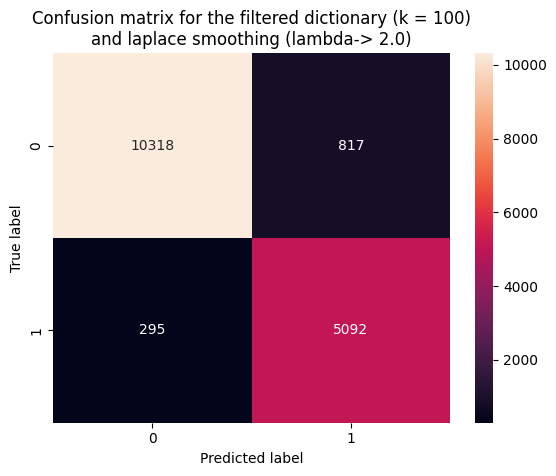

In [42]:
# Let's check the confusion matrix for the filtered dictionary (k = 100) and laplace smoothing (l0p1 = lambda-> 0.1)
actual_l0p1 = test_df_l0p1['category']
predicted_l0p1 = test_df_l0p1['predicted']
cm_l0p1 = confusion_matrix(actual_l0p1, predicted_l0p1, labels=[1, 0])

# Plot of the confusion matrix
sns.heatmap(cm_l0p1, annot=True, fmt='d')
plt.title('Confusion matrix for the filtered dictionary (k = 100)\nand laplace smoothing (lambda-> 2.0)', fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [43]:
# Accuracy, Precision, Recall and F1 Score for the filtered dictionary (k = 100) and laplace smoothing (l0p1 = lambda-> 0.1)
accuaracy_l0p1 = accuracy_score(actual_l0p1, predicted_l0p1)
precision_l0p1 = precision_score(actual_l0p1, predicted_l0p1)
recall_l0p1 = recall_score(actual_l0p1, predicted_l0p1)
f1_l0p1 = f1_score(actual_l0p1, predicted_l0p1)

print(f"Accuracy = {accuaracy_l0p1}")
print(f"Precision = {precision_l0p1}")
print(f"Recall = {recall_l0p1}")
print(f"F1 score = {f1_l0p1}")

Accuracy = 0.9326957995400073
Precision = 0.9722039008762838
Recall = 0.9266277503367759
F1 score = 0.948868861504506


#### For Lambda = 0.005

In [44]:
# Initialize laplace smoothing parameter and the number of classes
laplace_smoothing_val = 0.005
num_classes = 2
spam_word_probs, ham_word_probs = laplace_smoothing(feature_matrix_spam, feature_matrix_ham, laplace_smoothing_val, num_classes, filtered_dict_100)

# Copy the test_df and drop predicted column (l0p005 = lambda-> 0.005)
test_df_l0p005 = test_df.copy()

# Classify the emails
test_df_l0p005['predicted'] = test_df_l0p005['email_message'].apply(lambda x: classify(x, spam_word_probs, ham_word_probs, p_spam, p_ham, filtered_dict_100, filtered_dict_100_list))
test_df_l0p005

,folder,file,email_message,category,predicted
21300,71,0,hesitantly derive perverse satisfaction clodho...,1,1
21301,71,1,things perform experiment display will remain ...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa naa...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,prosperous future increased money earning powe...,1,1


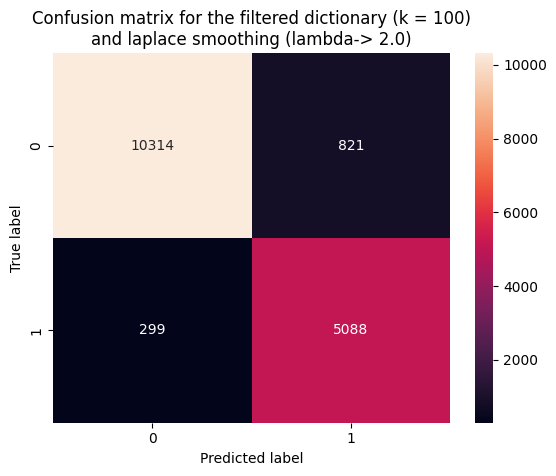

In [45]:
# Let's check the confusion matrix for the filtered dictionary (k = 100) and laplace smoothing (l0p005 = lambda-> 0.005)
actual_l0p005 = test_df_l0p005['category']
predicted_l0p005 = test_df_l0p005['predicted']
cm_l0p005 = confusion_matrix(actual_l0p005, predicted_l0p005, labels=[1, 0])

# Plot of the confusion matrix
sns.heatmap(cm_l0p005, annot=True, fmt='d')
plt.title('Confusion matrix for the filtered dictionary (k = 100)\nand laplace smoothing (lambda-> 2.0)', fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [46]:
# Accuracy, Precision, Recall and F1 Score for the filtered dictionary (k = 100) and laplace smoothing (l0p005 = lambda-> 0.005)
accuaracy_l0p005 = accuracy_score(actual_l0p005, predicted_l0p005)
precision_l0p005 = precision_score(actual_l0p005, predicted_l0p005)
recall_l0p005 = recall_score(actual_l0p005, predicted_l0p005)
f1_l0p005 = f1_score(actual_l0p005, predicted_l0p005)

print(f"Accuracy = {accuaracy_l0p005}")
print(f"Precision = {precision_l0p005}")
print(f"Recall = {recall_l0p005}")
print(f"F1 score = {f1_l0p005}")

Accuracy = 0.9322115966590001
Precision = 0.9718270046169791
Recall = 0.926268522676246
F1 score = 0.9485010115872723


In [47]:
# Create a table for the accuracy, precision, recall and f1 score for the lambda values (l2, l1=original filtered (k=100), l0p5, l0p1, l0p005)
lambda_tables = pd.DataFrame({'Accuracy': [accuaracy_l2, accuracy_100, accuaracy_l0p5, accuaracy_l0p1, accuaracy_l0p005],
'Precision': [precision_l2, precision_100, precision_l0p5, precision_l0p1, precision_l0p005],
'Recall': [recall_l2, recall_100, recall_l0p5, recall_l0p1, recall_l0p005]}, index=['lambda-> 2.0', 'lambda-> 1.0', 'lambda-> 0.5', 'lambda-> 0.1', 'lambda-> 0.005'])
lambda_tables

,Accuracy,Precision,Recall
lambda-> 2.0,0.932514,0.972018,0.926538
lambda-> 1.0,0.932938,0.972125,0.927077
lambda-> 0.5,0.932635,0.972201,0.926538
lambda-> 0.1,0.932696,0.972204,0.926628
lambda-> 0.005,0.932212,0.971827,0.926269


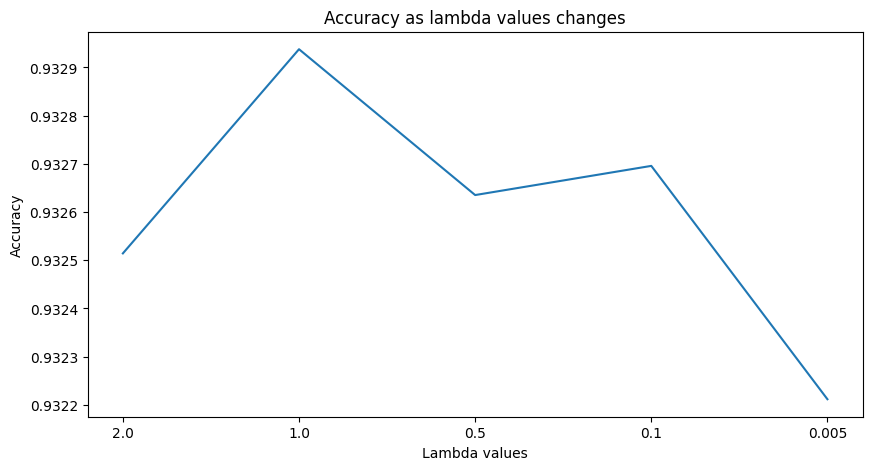

In [48]:
# Plot of the accuracy as lambda values changes
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(['2.0', '1.0', '0.5', '0.1', '0.005'], [accuaracy_l2, accuracy_100, accuaracy_l0p5, accuaracy_l0p1, accuaracy_l0p005])
ax.set_title('Accuracy as lambda values changes', fontsize=12)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Lambda values')
plt.show()

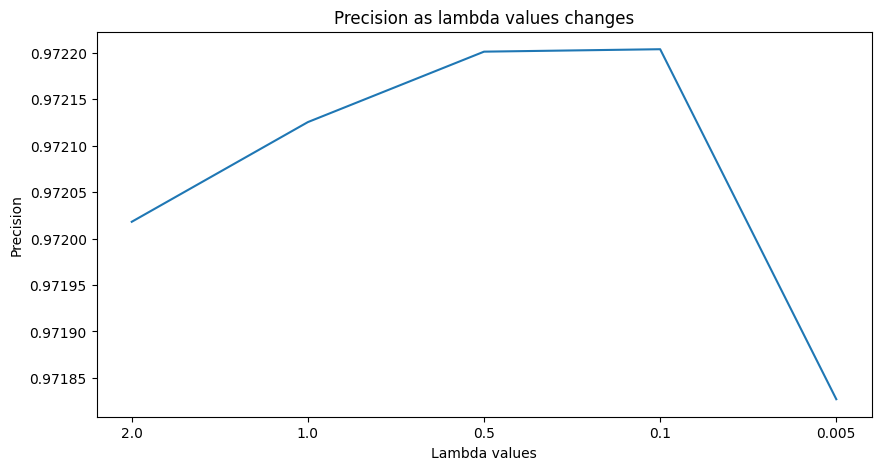

In [49]:
# Plot of the precision as lambda values changes
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(['2.0', '1.0', '0.5', '0.1', '0.005'], [precision_l2, precision_100, precision_l0p5, precision_l0p1, precision_l0p005])
ax.set_title('Precision as lambda values changes', fontsize=12)
ax.set_ylabel('Precision')
ax.set_xlabel('Lambda values')
plt.show()

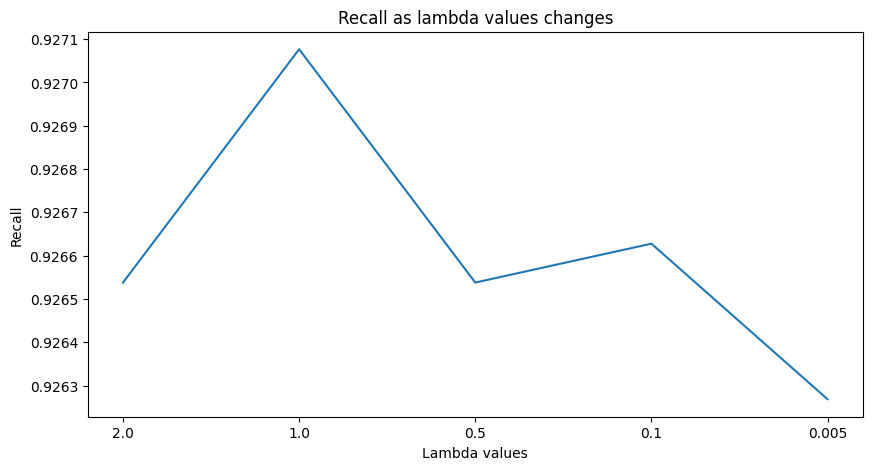

In [50]:
# Plot of the recall as lambda values changes
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(['2.0', '1.0', '0.5', '0.1', '0.005'], [recall_l2, recall_100, recall_l0p5, recall_l0p1, recall_l0p005])
ax.set_title('Recall as lambda values changes', fontsize=12)
ax.set_ylabel('Recall')
ax.set_xlabel('Lambda values')
plt.show()